In [1]:
import sys
from temgymbasic.model import (
    Model,
)
from temgymbasic import components as comp
import matplotlib.pyplot as plt
from PySide6.QtWidgets import QApplication
from temgymbasic.gui import TemGymWindow

import numpy as np
from temgymbasic.utils import calculate_phi_0
from temgymbasic import gbd

from typing import Tuple, NamedTuple
from temgymbasic.plotting import plot_model
%matplotlib ipympl

In [2]:
%load_ext autoreload
%reload_ext autoreload

def zero_phase(u, idx_x, idx_y):
    u_centre = u[idx_x, idx_y]
    phase_difference =  0 - np.angle(u_centre)
    u = u * np.exp(1j * phase_difference)
    
    return u
     

def abssqr(x):
    # this is what a detector sees (only intensities)
    return np.real(x*np.conj(x))

def FT(x):
    # this only defines the correct fwd fourier transform including proper shift of the frequencies
    return np.fft.fftshift(np.fft.fft2(x)) # Fourier transform and shift

def iFT(x):
    # this only defines the correct inverse fourier transform including proper shift of the frequencies
    return np.fft.ifft2(np.fft.ifftshift(x)) # inverse Fourier transform and shift
    
import numpy as np

def FresnelPropagator(E0, ps, lambda0, z):
    """
    Parameters:
        E0 : 2D array
            The initial complex field in the x-y source plane.
        ps : float
            Pixel size in the object plane (same units as wavelength).
        lambda0 : float
            Wavelength of the light (in the same units as ps).
        z : float
            Propagation distance (in the same units as ps).

    Returns:
        Ef : 2D array
            The complex field after propagating a distance z.
    """
    k = 2 * np.pi / lambda0  # Wavenumber
    
    n, m = E0.shape  # Get the size of the input field

    # Frequency coordinates (Fourier space)
    fx = np.fft.fftfreq(n, ps)
    fy = np.fft.fftfreq(m, ps)
    Fx, Fy = np.meshgrid(fx, fy)
    
    # Compute the Fresnel kernel in Fourier space
    H = np.exp(-1j*(2 * np.pi / lambda0) * z) * np.exp(-1j * np.pi * lambda0 * z * (Fx**2 + Fy**2))
    
    # Fourier transform of the initial field
    E0fft = np.fft.fft2(E0)
    
    # Multiply by the transfer function
    G = H * E0fft
    
    # Inverse Fourier transform to get the propagated field
    Ef = np.fft.ifft2(G)
    
    return Ef

import numpy as np

def lens_phase_factor(n, ps, lambda0, f):
    """
    Compute the phase factor introduced by an ideal lens.
    
    Parameters:
        n : int
            Number of pixels (assuming square grid, n x n).
        ps : float
            Pixel size (in the same units as wavelength and focal length).
        lambda0 : float
            Wavelength of the light (in the same units as ps).
        f : float
            focal length of the lens (in the same units as ps).
    
    Returns:
        phase_factor : 2D array (n x n)
            The phase factor to multiply with the field.
    """
    # Create coordinate grid
    x = np.linspace(-n/2, n/2 - 1, n) * ps
    y = np.linspace(-n/2, n/2 - 1, n) * ps
    X, Y = np.meshgrid(x, y)
    
    # Calculate the phase factor
    phase_factor = np.exp(-1j * np.pi * (X**2 + Y**2) / (lambda0 * f) + 1j * np.pi)
    
    return phase_factor


In [3]:
def make_detector_for_gauss_rays(x_det, y_det, n_rays):
    x,y = np.meshgrid(x_det, y_det)
    
    r = np.array([x.ravel(), y.ravel()]).T
    r = np.broadcast_to(r, [n_rays, *r.shape])
    r = np.swapaxes(r, 0, 1)

    return r

In [4]:
n_rays = 1
wavelength = 0.12
k = 2 * np.pi / wavelength

wavelengths = np.full(n_rays, wavelength)
a = 5
focal = 8
b = 12

size = 1000
det_shape = (size, size)
pixel_size = 10 / size
dsize = det_shape[0] * pixel_size
print(dsize)

x_det = np.linspace(-dsize / 2, dsize / 2, size)

wo = 0.4
wos = np.full(n_rays, wo)

div = wavelength / (np.pi * wo)

dPx = wo
dPy = wo
dHx = div
dHy = div

z_r = (np.pi * wo ** 2) / wavelengths 

theta_x = -0
theta_y = 0

deg_yx = np.deg2rad((theta_y, theta_x ))
tilt_yx = np.tan(deg_yx)

x0 = 1
y0 = 0

10.0


In [5]:
components = (
    comp.GaussBeam(
        z=0.0,
        voltage=calculate_phi_0(wavelength),
        radius=x0,
        wo=wo,
        tilt_yx=tilt_yx
    ),
    comp.Lens(
        z = a,
        f = focal,
    ),
    comp.AccumulatingDetector(
        z=a + b,
        pixel_size=pixel_size,
        shape=det_shape,
        buffer_length=64,
    ),
)

In [6]:
model = Model(components)
rays = tuple(model.run_iter(num_rays=n_rays))
image = model.detector.get_image(rays[-1])
det_x = np.linspace(-det_shape[1]//2*pixel_size, det_shape[1]//2*pixel_size, det_shape[1])

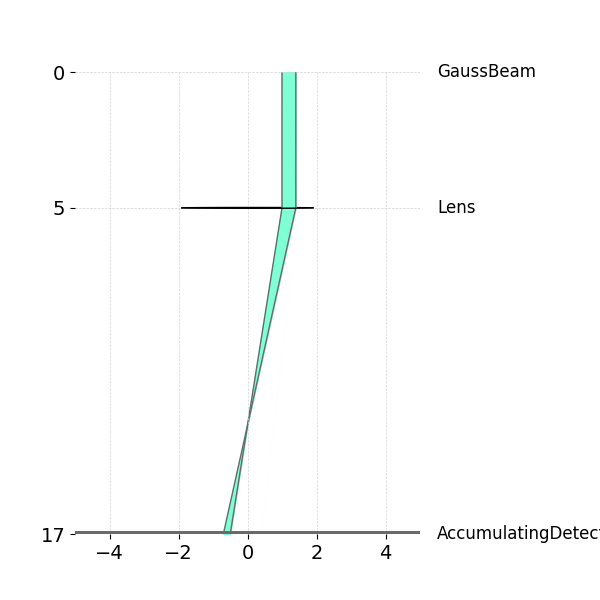

In [7]:
fig, ax = plot_model(model)

In [8]:
end_rays = rays[-1].data[0:4, :].T
path_length = rays[-1].path_length[0::5]

split_end_rays = np.split(end_rays, n_rays, axis=0)
split_path_length = np.split(path_length, n_rays, axis=0)

rayset1 = np.stack(split_end_rays, axis=-1)

xEnd, yEnd = rayset1[0, 0], rayset1[0, 2]
lEnd, mEnd = rayset1[0, 1], rayset1[0, 3]

In [9]:
#get misalignment vectors
x1m = rays[1].data[0, 0::5]
phi_x1m = rays[0].data[1, 0::5]
y1m = rays[1].data[2, 0::5]
phi_y1m = rays[0].data[3, 0::5]

x2m = rays[-2].data[0, 0::5]
phi_x2m = rays[-2].data[1, 0::5]
y2m = rays[-2].data[2, 0::5]
phi_y2m = rays[-2].data[3, 0::5]

r1m = np.array([x1m - x0, y1m - y0]).T
p1m = np.array([phi_x1m, phi_y1m]).T
r2m = np.array([x2m - xEnd, y2m - yEnd]).T
p2m = np.array([phi_x2m, phi_y2m]).T

print(r1m.shape, p1m, r2m, p2m)

(1, 2) [[0. 0.]] [[1.5 0. ]] [[-0.125  0.   ]]


In [10]:
r2 = make_detector_for_gauss_rays(x_det, x_det, n_rays)
r = r2.copy()

r[:, :,  0] = r2[:, :,  0] - xEnd
r[:, :,  1] = r2[:, :,  1] - yEnd

In [11]:
A, B, C, D = gbd.differential_matrix(rayset1, dPx, dPy, dHx, dHy)

In [12]:
Qinv = gbd.calculate_Qinv(z_r)
Qpinv = gbd.calculate_Qpinv(A, B, C, D, Qinv)
field = gbd.propagate_misaligned_gaussian(Qinv, Qpinv, r, r1m, p1m, r2m, p2m, r2, k, A, B, path_length).reshape(det_shape)
field = zero_phase(field, size//2, size//2)

IndexError: index 1 is out of bounds for axis 1 with size 1

Text(0.5, 0.98, 'GBP')

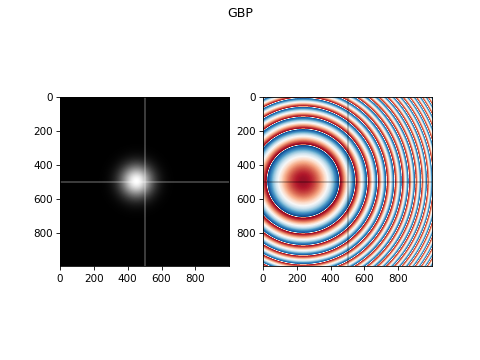

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.abs(field),cmap='gray')
ax1.axvline(size // 2, color='white', alpha=0.3)
ax1.axhline(size // 2, color='white', alpha=0.3)
ax2.imshow(np.angle(field),cmap='RdBu')
ax2.axvline(size // 2, color='k', alpha=0.3)
ax2.axhline(size // 2, color='k', alpha=0.3)
fig.suptitle("GBP")

In [ ]:
from diffractio import degrees
from diffractio.scalar_sources_XY import Scalar_source_XY
from diffractio.scalar_masks_XY import Scalar_mask_XY

# Calculate theta and phi
tan_theta_x = np.tan(deg_yx[1])
tan_theta_y = np.tan(deg_yx[0])

theta = np.arctan(np.sqrt(tan_theta_x**2 + tan_theta_y**2))
phi = np.arctan2(tan_theta_y, tan_theta_x)

u1 = Scalar_source_XY(x=x_det, y=x_det, wavelength = wavelength)
u1.gauss_beam(A=1, r0=(x0, 0), z0=0, w0=(wo, wo), theta=theta, phi=phi)
t1 = Scalar_mask_XY(x=x_det, y=x_det, wavelength = wavelength)
t1.lens(r0 = (0, 0), radius=0, focal=focal)

#If you just want the gaussian at some z, for example z = 10
u1 = u1.RS(z=a)
u2 = u1 * t1
u3 = u2.RS(z=b)

single_gaussian = u3.u
single_gaussian = zero_phase(single_gaussian, size//2, size//2)


Text(0.5, 0.98, 'DiffIO')

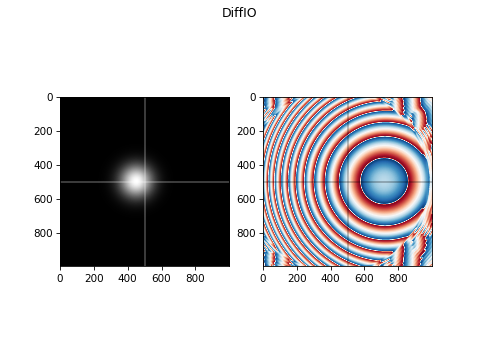

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.abs(single_gaussian), cmap='gray')
ax2.imshow(np.angle(single_gaussian),cmap='RdBu')
ax1.axvline(size // 2, color='white', alpha=0.3)
ax1.axhline(size // 2, color='white', alpha=0.3)
ax2.axvline(size // 2, color='k', alpha=0.3)
ax2.axhline(size // 2, color='k', alpha=0.3)
fig.suptitle("DiffIO")

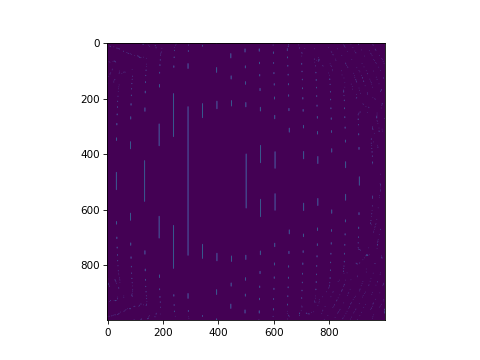

In [ ]:
fig, ax1 = plt.subplots()
ax1.imshow(
    np.isclose(
        np.angle(single_gaussian),
        np.angle(field),
        atol=0.01,
    )
)

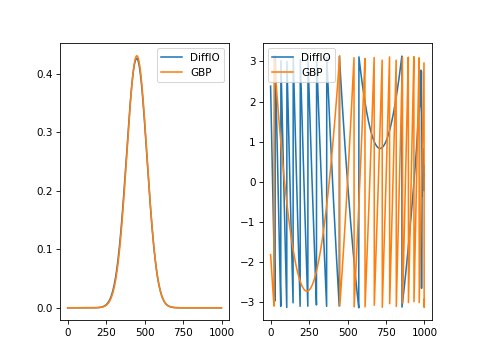

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
s = np.s_[size // 2, :]
ax1.plot(np.abs(single_gaussian[s]), label="DiffIO")
ax1.plot(np.abs(field[s]), label="GBP")
ax1.legend()
ax2.plot(np.angle(single_gaussian[s]), label="DiffIO")
ax2.plot(np.angle(field[s]), label="GBP")
ax2.legend()

In [ ]:

u1 = Scalar_source_XY(x=x_det, y=x_det, wavelength=wavelength)
u1.gauss_beam(A=1, r0=(x0, 0), z0=0, w0=(wo, wo), theta=theta, phi=phi)
u1 = FresnelPropagator(u1.u, pixel_size, wavelength, a)
u2 = u1 * lens_phase_factor(size, pixel_size, wavelength, focal)
u3 = FresnelPropagator(u2, pixel_size, wavelength, b)

u3 = zero_phase(u3, size//2, size//2)

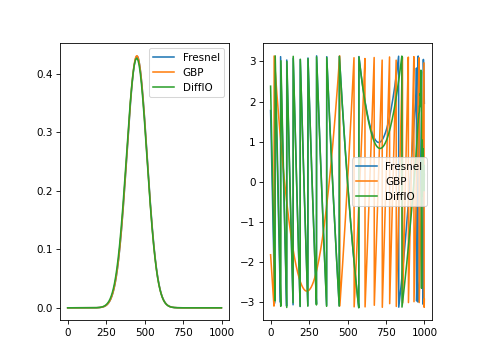

In [ ]:

fig, (ax1, ax2) = plt.subplots(1, 2)
s = np.s_[size // 2, :]
ax1.plot(np.abs(u3[s]), label="Fresnel")
ax1.plot(np.abs(field[s]), label="GBP")
ax1.plot(np.abs(single_gaussian[s]), label="DiffIO")
ax1.legend()
ax2.plot(np.angle(u3[s]), label="Fresnel")
ax2.plot(np.angle(field[s]), label="GBP")
ax2.plot(np.angle(single_gaussian[s]), label="DiffIO")
ax2.legend()